# Chilean pig and bird data

This notebook examines data from the Register of Livestock Establishments ([Registro de Establecimientos Pecuarios](https://www.sag.gob.cl/ambitos-de-accion/registro-de-establecimientos-pecuarios)) maintained by the Agriculture and Livestock Service of the Chilean Agricultural Ministry. According to the web page, "The RUP corresponds to the mandatory identification of each livestock establishment in the country." The data were obtained (with some difficulty) under Chilean transparency laws by C. Leibsch, a Chilean researcher and animal advocate.

There is one spreadsheet for "pigs" and another for "birds". The spreadsheets don't contain any further information about animal type or life stage, but they do contain farm coordinates and animal numbers, along with some other geographical information (such as the Chilean region each establishment is in).

The notebook has the same basic structure as the one for Iowa (of course, adapted as appropriate for the characteristics of this location and dataset). The main aims are to:

1. Understand how similar Chilean pig and poultry housing is to that found in Iowa, in terms of its size and shape  (*between-country diversity*)
1. Find out how standardized Chilean animal housing is, on farms that would be considered medium or large CAFOs by the US-EPA (*within-country diversity*)
1. Estimate the fraction of Chilean pigs and poultry that exist on medium and large CAFOs
1. Obtain a set of farm and not-farm locations for model training

## Setup

In [ ]:
try:
  import unidecode
except ModuleNotFoundError:
  !pip install pyogrio==0.7.2 geopandas==0.14.3 unidecode

In [ ]:
%load_ext autoreload
%autoreload 2

import sys, os
from IPython.core.magic import register_cell_magic
from glob import glob
import numpy as np
from unidecode import unidecode
from google.colab import drive
import ee
import geemap.foliumap as geemap
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import pyproj
import pyarrow

gpd.options.io_engine = "pyogrio"
os.environ["PYOGRIO_USE_ARROW"] = "1"
pd.options.display.float_format = '{:.0f}'.format

In [ ]:
ee.Authenticate()
ee.Initialize(project="215656163750")
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
import utils, explore

@register_cell_magic
def skip(line, cell):
    return

path = "/content/drive/MyDrive/CAFO_data/"

Mounted at /content/drive


## Basic farm information

The Chile data are associated with numbers of animals per farm, so we can look at (1) the distribution of farm sizes, and (2) the numbers of animals on farms of different sizes. Although this is just one country, it starts to give some insight into the fraction of animals that exist in industrial facilities as opposed to smaller farms. That is interesting for a few reasons, but for this project it will help us understand whether the type of standardized facilities we are likely to be able to detect house the majority of the animals.

Here are some quantities we will use later in the notebook:

* Pigs
  * Potentially interesting: 250 - 749 pigs
  * EPA medium CAFO: 750 - 2499 pigs
  * EPA large CAFO: >= 2500 pigs
* Poultry
  * Potentially interesting: 10,000 - 29,999 birds
  * EPA medium CAFO: 30,000 - 99,999 birds
  * EPA large CAFO: >= 100,000 birds

Why these numbers? First, I want to compare whether buildings on farms that would be classed as medium and large CAFOs by the US EPA have the same kinds of characteristics that we saw in the Iowa dataset. This gives some information about how diverse larger farms are, and therefore how easy or difficult it will be to identify them in different countries.

I've also included a "potentially interesting" category which includes smaller farms. This might show whether there is some threshold at which farms start to become much more diverse and less standardized. That all helps to show what kind of farms we are likely to detect or miss, and how many animals they account for. (I could just include all the farms in the dataset, but then the data volume becomes difficult to handle.)

It's important to remember that the EPA CAFO thresholds are defined in terms of animal units, while the Chile dataset gives animal numbers. Animal units are defined differently for different animal species and life stages (see the Iowa notebook), but the Chile dataset doesn't give much information about that. For example, ducks, small and large turkeys, and small and large chickens all have different AU <--> animal number conversions, but the Chile dataset only specifies "bird". So, to obtain the above animal numbers, I have assumed 1 AU = 2.5 pigs and 100 birds.

In [ ]:
df1 = pd.read_excel('/content/drive/MyDrive/CAFO_data/Chile/RUP-porcinos-2022 (1).xlsx')
df2 = pd.read_excel('/content/drive/MyDrive/CAFO_data/Chile/RUP-aves-2022 (2) (3).xlsx')

In [ ]:
pig_numbers = {"potentially_interesting": 250, "epa_medium_cafo":750, "epa_large_cafo":2500}
bird_numbers = {"potentially_interesting": 10000, "epa_medium_cafo":32000, "epa_large_cafo":100000}

Printing some information about the data (next cell) shows that:

1.   There are many farms with CANTIDAD=0. It is not clear why this is, or how many farms these animals might actually have. I suspect they will be very small farms, but I'm not sure about that. For the time being, we will treat these farms as having an unknown quantity of animals.
2.   There are some farms with very large animal numbers. For example, the largest pig farm claims to have 53133 pigs (cf 37200 in the Iowa dataset). Visually inspecting images of those farms shows that they are real and are large CAFOs. It is not clear that they are larger than other CAFOs, though. I suspect that some of these very large "farms" could actually represent companies that have a lot of animals spread over different facilities, but I'm not sure about that.

Overall, it seems that the animal numbers in this dataset are useful but should be used with some caution.

In [ ]:
def describe_data(df, animal_type, size_range):

  print(f"\nThere are {df.shape[0]} entries in the {animal_type} spreadsheet")

  x = df[df['COORDENADA_X'].isnull()]
  print(f"{len(x)} farms have invalid (NULL) coordinates")

  x = df[(df['CANTIDAD'] == 0) & (df['COORDENADA_X'].notnull())]
  print(f"{len(x)} farms (with valid coords) report 0 {animal_type}")

  for k, v in size_range.items():
    x = df[df['CANTIDAD'] >= v]
    print(f"There are {len(x)} farms above the '{k}' threshold (>={v} {animal_type})")
    print(f"  - They account for {x['CANTIDAD'].sum()} {animal_type}")

  print(f"The largest farm reports {df['CANTIDAD'].max()} {animal_type}")

describe_data(df1, 'pigs', pig_numbers)
describe_data(df2, 'birds', bird_numbers)


There are 44444 entries in the pigs spreadsheet
4191 farms have invalid (NULL) coordinates
26814 farms (with valid coords) report 0 pigs
There are 174 farms above the 'potentially_interesting' threshold (>=250 pigs)
  - They account for 2530906 pigs
There are 161 farms above the 'epa_medium_cafo' threshold (>=750 pigs)
  - They account for 2526282 pigs
There are 145 farms above the 'epa_large_cafo' threshold (>=2500 pigs)
  - They account for 2499824 pigs
The largest farm reports 53133 pigs

There are 45037 entries in the birds spreadsheet
4206 farms have invalid (NULL) coordinates
2843 farms (with valid coords) report 0 birds
There are 414 farms above the 'potentially_interesting' threshold (>=10000 birds)
  - They account for 64492116 birds
There are 281 farms above the 'epa_medium_cafo' threshold (>=32000 birds)
  - They account for 61810820 birds
There are 168 farms above the 'epa_large_cafo' threshold (>=100000 birds)
  - They account for 56100506 birds
The largest farm reports 5

The next cell creates histograms of number of animals per farm and cumulative animal numbers. The histograms contain farms of all sizes (except those with CANTIDAD=0), not just those in the ranges we defined a few cells ago.

Taken at face value, these plots indicate that the vast majority of *farms* are small. However, most *animals* are on farms that would be considered large CAFOs by the EPA's definition. This conclusion is probably robust for birds, as relatively few poultry farms report having 0 animals. For pigs, if all the farms reporting 0 animals really contained 100 pigs, we would conclude that about half of pigs live on smallish farms. That seems pretty unlikely though.




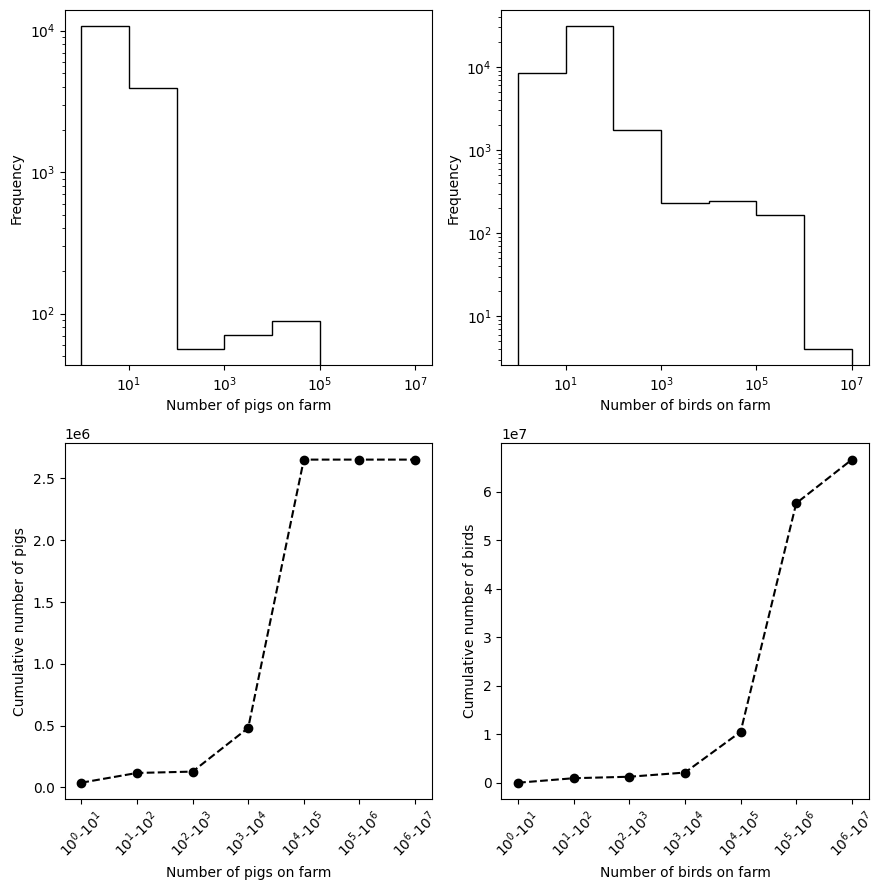

In [ ]:
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 9))

explore.histo(df1, ax1, ax3, 'pigs', 'CANTIDAD')
explore.histo(df2, ax2, ax4, 'birds', 'CANTIDAD')
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/CAFO_data/Analysis/Chile_farm_histos.png')

We will now filter the dataset to only farms that  have either 0 (= unknown number of) animals or CANTIDAD > the potentially_interesting threshold. We'll also convert coordinates from Eastings + Northings to Lat + Long, and tidy up the columns/column names a bit. Chile is a bit of a pain to work with because the north and south are in different UTM zones and require different CRSs.

In [ ]:
def refine_data(df, animal_type, sizes):

  print(f"\nStarting with {len(df)} {animal_type} farms")

  # Drop rows with invalid (NULL) coordinates
  df = df[(~df['COORDENADA_X'].isnull()) | (~df['COORDENADA_Y'].isnull())]
  print(f" --After dropping null coordinates, there are {len(df)} farms")

  # Drop rows that aren't in UTM zones 18 or 19. Other zones are offshore
  # islands and maybe the southern tip of Patagonia.
  df.loc[:, 'HUSO'] = df['HUSO'].astype(int)
  df = df[(df['HUSO'] == 18) | (df['HUSO'] == 19)]
  print(f" --After dropping farms outside UTM zones 18 and 19, there are\
 {len(df)} farms")

  # Limit to interesting farm sizes and rename the CANTIDAD column
  df = df[(df['CANTIDAD'] < 1) | (df['CANTIDAD'] > sizes['potentially_interesting'])]
  df.loc[:, "Number of animals"] = df.loc[:, "CANTIDAD"]
  print(f" --After restricting farm sizes, there are {len(df)} farms")

  df.loc[:, "Farm type"] = animal_type

  # Define the appropriate CRS for the UTM zone
  df['CRS'] = ''
  df.loc[df['HUSO'] == 19, ['CRS']] = 'EPSG:20049'
  df.loc[df['HUSO'] == 18, ['CRS']] = 'EPSG:20048'

  # Convert from Eastings and Northings to Lat and Long
  for crs in ['EPSG:20048', 'EPSG:20049']:
    temp = df[df['CRS'] == crs].copy()
    trans = pyproj.Transformer.from_crs(crs_from=crs, crs_to="epsg:4326")
    xx, yy = trans.transform(temp["COORDENADA_X"].values, temp["COORDENADA_Y"].values)
    df.loc[temp.index, 'Longitude'] = yy
    df.loc[temp.index, 'Latitude'] = xx

  gdf = gpd.GeoDataFrame(df, geometry=\
                       gpd.points_from_xy(df["Longitude"], df["Latitude"],\
                                          crs="EPSG:4326"))

  # Drop columns we no longer need
  gdf = gdf.drop(columns=["Latitude", "Longitude", "COORDENADA_X", "COORDENADA_Y",\
                          "DIRECCION_ESTABLECIMIENTO", "LOCALIDAD", "CANTIDAD",\
                          "REGION", "PROVINCIA", "COMUNA", 'OFICINA', 'RUP',\
                          'RUP_NOMBRE', 'HUSO'])


  return gdf

In [ ]:
birds = refine_data(df2, 'Poultry', bird_numbers)
pigs = refine_data(df1, 'Pig', pig_numbers)

print(f"\nAt this point there are {len(pigs) + len(birds)} farms in total")


Starting with 45037 Poultry farms
 --After dropping null coordinates, there are 40831 farms
 --After dropping farms outside UTM zones 18 and 19, there are 40767 farms
 --After restricting farm sizes, there are 3239 farms

Starting with 44444 Pig farms
 --After dropping null coordinates, there are 40253 farms
 --After dropping farms outside UTM zones 18 and 19, there are 40189 farms
 --After restricting farm sizes, there are 26947 farms

At this point there are 30186 farms


The government records consist of a pig spreadsheet and a poultry one, but in reality some farms could contain both pigs and birds. These should be identified as "Mixed" farms, in the same way as for the Iowa data.

In [ ]:
def find_mixed_farms(pigs, birds, crs, dist=20):

  temp1 = pigs[pigs['CRS'] == crs].to_crs(crs)
  temp2 = birds[birds['CRS'] == crs].to_crs(crs)
  result = temp1.sjoin_nearest(temp2, how="inner", max_distance=dist,\
                               distance_col="Distances")

  result = result.to_crs("EPSG:4326")

  return result

# Find the mixed farms
mixed_north = find_mixed_farms(pigs, birds, 'EPSG:20049')
mixed_south = find_mixed_farms(pigs, birds, 'EPSG:20048')
mixed = pd.concat([mixed_north, mixed_south])

# Drop them from the original pig and bird datasets
pigs_only = pigs[~pigs.index.isin(mixed.index)]
birds_only = birds[~birds.index.isin(mixed["index_right"])]

# Sort out the mixed farm df
# Some pig farms have multiple poultry farms within <dist>. That doesn't make
# a lot of sense, and the one I inspected has nonsense coords anyway (in the
# ocean). For these ones, we will sum all the poultry numbers and drop the
# duplicate poultry farms
agg_dict = {k:v for k, v in zip(mixed.columns, ['first'] * len(mixed.columns))}
agg_dict['Number of animals_right'] = 'sum'
mixed = gpd.GeoDataFrame(mixed.groupby(mixed.index).agg(agg_dict)).\
                         set_crs("EPSG:4326")
mixed = mixed[~mixed.index.duplicated(keep='first')]

# Edit the columns so we can concatenate the pig, poultry, and mixed dfs
mixed.loc[:, "Number of animals"] = mixed["Number of animals_left"] +\
                                    mixed["Number of animals_right"]
mixed.loc[:, "Farm type"] = "Mixed"
mixed.loc[:, "CRS"] = mixed["CRS_left"]

for column in mixed.columns:
  if "_" in column:
    mixed.drop(columns=column, inplace=True)
mixed.drop(columns=["Distances"], inplace=True)

# Concatenate all the dfs
all_farms = pd.concat([pigs_only, birds_only, mixed])
print(f"There are now {len(all_farms)} farms in total:")
print(f" -- {len(pigs_only)} pig farms")
print(f" -- {len(birds_only)} poultry farms")
print(f" -- {len(mixed)} mixed farms")

There are now 29979 farms in total:
 -- 26446 pig farms
 -- 3032 poultry farms
 -- 501 mixed farms


## Associate farms with buildings

As with the Iowa dataset, we now:

* Find all the buildings larger than 200 sq m are within 150 m of each farm's coordinates

* Create a dataset of all the buildings larger than our minimum size that are > 1000 km from any farm coordinates

* Filter the farm building dataset down to just the largest building within 150 m of each farm's coordinates

* Calculate the lengths and aspect ratios of those farm buildings

However, we won't do this for the entire country. Instead, we will only look at the comunas (ADM3-level administrative districts) that contain at least one farm above the potentially_interesting size threshold. That way we will get a good sample of the farms with 0/unknown animals so we can figure out what they are. However, as I suspect they are predominantly small farms, we won't bother including all the comunas that *only* contain these farms.



In [ ]:
comunas = gpd.read_file(\
            '/content/drive/MyDrive/CAFO_data/Chile/shapefiles/chl_admbnda_adm3_bcn_20211008.shp'\
                          )
comunas.crs="EPSG:4326"
comunas = comunas[['ADM3_ES', 'geometry']].rename(columns={"ADM3_ES": "Comuna"})
print(f"There are {len(comunas)} Comunas in Chile")

There are 345 Comunas in Chile


In [ ]:
# Create a df containing a multipolygn representing the comunas that contain at
# least 1 farm above the potentially_interesting threshold, and a df of the
# farms that have coords within these comunas.

# Find intersection of comunas and farms, retaining geometry of the parent farm
all_farms.loc[:, 'temp geom'] = all_farms.loc[:, 'geometry']
joined = comunas.sjoin(all_farms, how='inner', predicate='intersects')

# Identify the comunas that contain at least 1 farm with >0 animals
comunas_of_interest = joined.groupby(["Comuna"])["Number of animals"].sum()
comunas_of_interest = comunas_of_interest[comunas_of_interest > 0].index

# Retain only rows in the joined farms-comunas df that are in those comunas
joined = joined[joined['Comuna'].isin(comunas_of_interest)]

# Create df of comunas that contain farms with >0 animals
comunas_w_farms = joined[~joined.index.duplicated(keep='first')]
comunas_w_farms = comunas_w_farms[comunas.columns]

# Create a df in which all these comunas are represented by a single multipolygon
single_geom = comunas_w_farms.drop(columns=["Comuna"]).dissolve(by=None)

# Create df of farms within comunas of interest
chile_farms = joined[all_farms.columns].drop(columns=['geometry'])\
              .set_geometry('temp geom').rename(columns={"temp geom": "geometry"})

print(f"There are {len(chile_farms)} farms with coords within the comunas of\
 interest")
print(f" -- {len(chile_farms[chile_farms['Farm type'] == 'Pig'])} pig farms")
print(f" -- {len(chile_farms[chile_farms['Farm type'] == 'Poultry'])} poultry farms")
print(f" -- {len(chile_farms[chile_farms['Farm type'] == 'Mixed'])} mixed farms")

There are 7728 farms with coords within the comunas of interest
 -- 6664 pig farms
 -- 955 poultry farms
 -- 109 mixed farms


The top 30 Comuna account for 5293/7728 farms (68%)


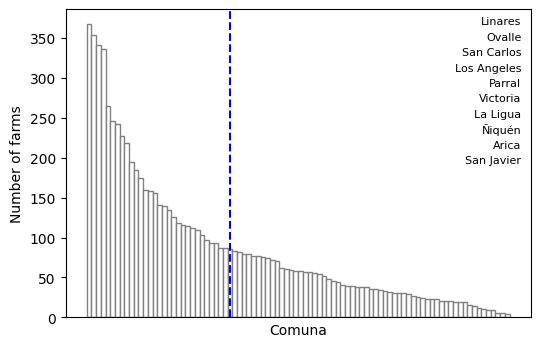

In [ ]:
# Plot the distribution of farms by comuna

_, ax = plt.subplots(1, 1, figsize=(6, 4))
explore.farms_per_region(joined, ax, 30, 'Comuna')
plt.savefig('/content/drive/MyDrive/CAFO_data/Analysis/Chile_farms_per_comuna.png')

In [ ]:
min_building_size = 200

In [ ]:
%%skip

# Skip this cell unless there's some reason to recreate the building file, e.g
# if min_building_size has changed. Read the existing file in the next cell
# instead
buildings_fc = (
      ee.FeatureCollection(f"projects/sat-io/open-datasets/VIDA_COMBINED/CHL")
      .filter(ee.Filter.gt('area_in_meters', min_building_size))
)

utils.write_to_file(buildings_fc, f"buildings_{min_building_size}_sq_m", 'Chile')
utils.ee_task_status()

In [ ]:
%%time

# Read the file of Chilean buildings > min_building_size
buildings = gpd.read_file(\
            f"/content/drive/MyDrive/CAFO_data/Chile/buildings_{min_building_size}_sq_m.geojson")
buildings.rename(columns={"area_in_meters": "Area (sq m)"}, inplace=True)
print(f"There are {len(buildings)} buildings > {min_building_size} sq m in Chile")

There are 879359 buildings > 200 sq m in Chile
CPU times: user 1min 43s, sys: 2.56 s, total: 1min 46s
Wall time: 1min 53s


In [ ]:
# Filter the buildings dataset to just the comunas of interest

farm_comuna_bldgs = buildings.sjoin(single_geom, how='inner', predicate='within')
farm_comuna_bldgs = farm_comuna_bldgs.filter(["Area (sq m)", "geometry"])
print(f"There are {len(farm_comuna_bldgs)} buildings > {min_building_size} sq m in\
 the comunas of interest")

There are 347009 buildings > 200 sq m in the comunas of interest


In [ ]:
# Find all the buildings that are within <farm_dist> m of a
# farm, and those that are more than <not_farm_dist> away

farm_dist = 150
not_farm_dist = 1000

# Farms in UTM 19S = EPSG:20049
temp = chile_farms[(chile_farms['geometry'].x > -72) &\
                   (chile_farms['geometry'].x < -66)].set_geometry('geometry')
crs = "EPSG:20049"
farm_buildings1, other_buildings1 = explore.join_farms_and_buildings(temp,\
                                                                  farm_comuna_bldgs,\
                                                                  farm_dist,\
                                                                  not_farm_dist,\
                                                                  crs)

# Farms in UTM 18S = EPSG:20048
temp = chile_farms[(chile_farms['geometry'].x > -78) &\
                   (chile_farms['geometry'].x < -72)].set_geometry('geometry')
crs = "EPSG:20048"
farm_buildings2, other_buildings2 = explore.join_farms_and_buildings(temp,\
                                                                  farm_comuna_bldgs,\
                                                                  farm_dist,\
                                                                  not_farm_dist,\
                                                                  crs)
farm_buildings = pd.concat([farm_buildings1, farm_buildings2])
other_buildings = pd.concat([other_buildings1, other_buildings2])

print(f"There are {len(farm_buildings)} buildings within {farm_dist} m of farm coords ")
print(f"There are {len(other_buildings)} buildings >{not_farm_dist} m from\
 farm coords (either type) ")

There are 22985 buildings within 150 m of farm coords 
There are 533277 buildings >1000 m from farm coords (either type) 


In [ ]:
# Some farms are dropped because they are not associated with buildings >
# min_building_size. Print some info about this.

new_total = 0
for farm_type in ["Pig", "Poultry", "Mixed"]:
  n = len(chile_farms[chile_farms["Farm type"] == farm_type])
  print(f"Started with {n} farms of type {farm_type}")

  n = len(farm_buildings[farm_buildings["Farm type"] == farm_type].\
             groupby(by="Parent coords"))
  print(f" -- {n} are associated with buildings > {min_building_size} sq m")
  new_total += n

print(f"There is now a total of {new_total} farms")

Started with 6664 farms of type Pig
 -- 4061 are associated with buildings > 200 sq m
Started with 955 farms of type Poultry
 -- 653 are associated with buildings > 200 sq m
Started with 109 farms of type Mixed
 -- 79 are associated with buildings > 200 sq m
There is now a total of 4793 farms


In [ ]:
# As we did for the Iowa data, we'll drop all but the largest building
# per farm, assuming this is likely to represent the animal housing instead of
# some random farm building

max_farm_bldgs = farm_buildings.sort_values('Area (sq m)', ascending=False)\
                              .drop_duplicates(['Parent coords'])
print(f"{len(farm_buildings)} buildings --> {len(max_farm_bldgs)} buildings")

22985 buildings --> 4793 buildings


In [ ]:
# Calculate the lengths and aspect ratios of the largest farm-associated
# buildings

temp = max_farm_bldgs[max_farm_bldgs['CRS'] == "EPSG:20049"]
set1 = explore.get_dimensions(temp, crs="EPSG:20049")

temp = max_farm_bldgs[max_farm_bldgs['CRS'] == "EPSG:20048"]
set2 = explore.get_dimensions(temp, crs="EPSG:20048")

max_farm_bldgs = pd.concat([set1, set2])

## Animal housing characteristics

### Stats + histograms

From the following cells:

* The pig farms we have animal numbers for are mostly large CAFOs. Both the median and 5%-ile building areas are larger than for large Iowa pig CAFOs. Judging by the histograms, the buildings tend to be longer and narrower as well.

* The pig housing looks a little less variable in Chile than in Iowa, based on the width of the histograms

* The poultry farms are more widely distributed among size classes. Their 5%-ile areas are larger, but their median areas are smaller. There is a smaller fraction of buildings with low aspect ratios, as well.

* The poultry housing also seems a bit less variable in Chile than in Iowa

* I think pig and poultry housing resemble each other more closely in Chile than in Iowa.
  * That might make sense if large animal farms developed over several decades in Iowa, but are a more recent import in Chile.

* For both pigs and poultry, the farms reporting 0 animals are predominantly associated with relatively small buildings. While there are exceptions, we will exclude these farms from the training dataset.



In [ ]:
def building_stats(farm_type, bins, numbers):

  print(f"\n====={farm_type}=====")

  _, (ax0, ax1) = plt.subplots(2, 3, figsize=(9, 6))

  df = pd.DataFrame()
  edit = farm_type.replace('s', '')

  temp = max_farm_bldgs[max_farm_bldgs["Farm type"] == edit]

  zero = temp[temp['Number of animals'] < 1]
  small = temp[(temp['Number of animals'] >= numbers['potentially_interesting']) &\
               (temp['Number of animals'] < numbers['epa_medium_cafo'])]
  medium = temp[(temp['Number of animals'] >= numbers['epa_medium_cafo']) &\
                (temp['Number of animals'] < numbers['epa_large_cafo'])]
  large = temp[temp['Number of animals'] >= numbers['epa_large_cafo']]

  for size, label, color in zip([zero, small, medium, large],\
                                ["N. animals=0", "Smaller",\
                                 "Medium", "Large"],\
                                ["k", "k", "b", "r"]):
    df.loc[f"{label}", f"N. farms"] = len(size)
    df.loc[f"{label}", "5%-ile area (sq m)"] = size["Area (sq m)"].quantile(0.05)
    df.loc[f"{label}", "50%-ile area (sq m)"] = size["Area (sq m)"].quantile(0.5)

    if label != "N. animals=0":
      axes = ax0
    else:
      axes = ax1
    for col, ax in zip(["Area (sq m)", "Length (m)", "Aspect ratio"], axes):
      ax.hist(size[col], bins=bins[col], histtype='step',\
              color=color, label=label)
      if col == "Area (sq m)":
        ax.legend(fontsize=9)
      ax.set_xlabel(col)
      ax.set_ylabel("Number of farms")

  display(df)
  plt.tight_layout()
  plt.show()

  return df


=====Pigs=====


,N. farms,5%-ile area (sq m),50%-ile area (sq m)
N. animals=0,3914,211,341
Smaller,6,645,2010
Medium,11,640,886
Large,130,908,1544


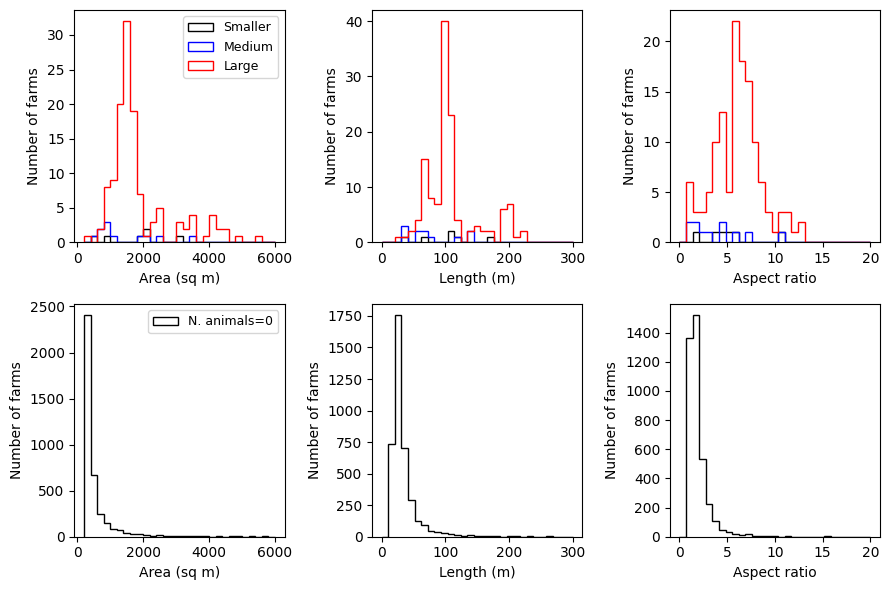

In [ ]:
bins = {}
bins['Area (sq m)'] = np.linspace(min_building_size, 6000, 30)
bins['Length (m)'] = np.linspace(0, 300, 30)
bins['Aspect ratio'] = np.linspace(0, 20, 30)

pig_stats = building_stats("Pigs", bins, pig_numbers)


=====Poultry=====


,N. farms,5%-ile area (sq m),50%-ile area (sq m)
N. animals=0,348,213,349
Smaller,99,596,2081
Medium,81,1047,2284
Large,125,1175,2051


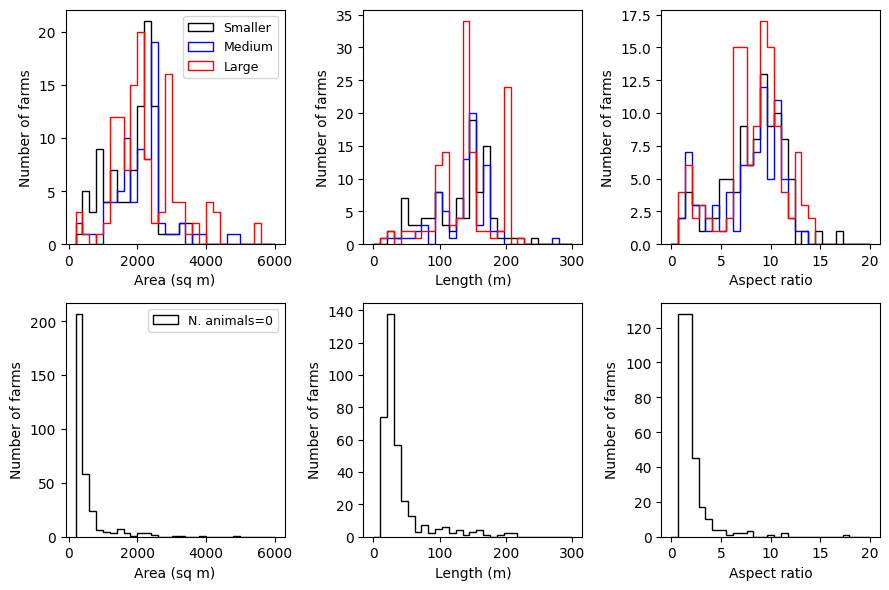

In [ ]:
poultry_stats = building_stats("Poultry", bins, bird_numbers)

In [ ]:
# Drop the farms with 0 animals and also the mixed farms

final_farm_bldgs = max_farm_bldgs[(max_farm_bldgs["Farm type"] != "Mixed") &\
                                  (max_farm_bldgs["Number of animals"] > 1)]

print(f"This leaves us with {len(final_farm_bldgs)} farms/buildings")

This leaves us with 452 buildings


### Aspect ratio vs area
The next plots show aspect ratio vs area for pig and poultry housing, color-coded by farm size. This is useful because it highlights a population of squarish buildings we might want to take a closer look at.

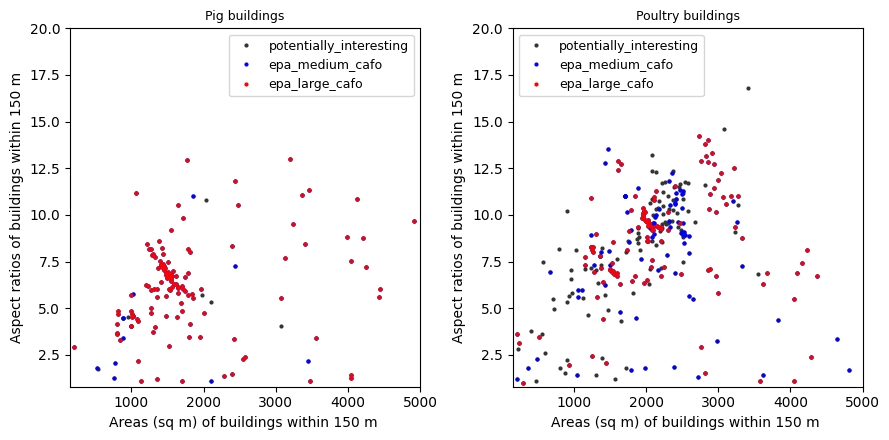

In [ ]:
# Plot aspect ratio vs area, color-coded by farm size

_, axes = plt.subplots(1, 2, figsize=(9, 4.5))

for ax, farm_type, threshold_dict in zip(axes, ['Pig', 'Poultry'],\
                                     [pig_numbers, bird_numbers]):

  to_plot = final_farm_bldgs[(final_farm_bldgs["Farm type"] == farm_type)]
  for size, color in zip(["potentially_interesting", "epa_medium_cafo",\
                          "epa_large_cafo"], ["0.2", "b", "r"]):
    to_plot = to_plot[to_plot["Number of animals"] > threshold_dict[size]]
    ax.plot(to_plot["Area (sq m)"], to_plot["Aspect ratio"], color=color, ms=2,\
            marker='o', ls='', label=size)
  ax.set_title(f"{farm_type} buildings", fontsize=9)

  ax.legend(fontsize=9)
  ax.set_xlim(min_building_size-50, 5000)
  ax.set_ylim(0.8, 20)
  ax.set_xlabel(f'Areas (sq m) of buildings within {farm_dist} m ')
  ax.set_ylabel(f'Aspect ratios of buildings within {farm_dist} m')

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/CAFO_data/Analysis/Chile_aspect_area.png")

## Visual inspection of final farm candidates

The farm buildings with aspect ratio < 2.5 turn out to be:

1. Buildings with inaccurate footprints in the MS-Google building footprint database, such as two adjacent, narrow buildings identified as a single, squarer one
1. Irregular buildings whose bounding box is larger than the actual building outline
1. Non-standard CAFOs, where the buildings are just not the usual type
1. Buildings not actually associated with CAFOs, because the farm coordinates in the official records were closer to a large non-farm building than to the farm buildings themselves.

We will leave the first 3 in the dataset but remove the 4th. (This is done after creating and examining the not-farm dataset.)

In [ ]:
# This function loops over all the rows in a df of farm or not-farm buildings.
# It shows each one in turn on a map. Type <keep> to retain the row, or <reject>
# to reject it

def loop_over_buildings(to_check):
  os.environ["HYBRID"] = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}'

  viz = {
      'color': 'yellow',
      'width': 2,
      'fillColor': '00000000'
  }

  false_positives = []
  for n in range(len(to_check)):
    feature = gpd.GeoDataFrame(to_check.iloc[n]).T.set_geometry('geometry')\
                                .set_crs("EPSG:4326")

    print(f"Working on feature {n} of {len(to_check)}")
    display(feature)
    fc = geemap.geopandas_to_ee(feature[['geometry']])

    Map = geemap.Map()
    Map.centerObject(fc.first().geometry(), 17)
    Map.add_basemap("HYBRID")
    Map.addLayer(fc, viz, "Not-farms")
    display(Map)

    response = input("Enter keep to keep, reject to reject, exit to exit  ")
    if response == 'reject':
      false_positives.append(feature.index[0])
    if response == 'exit':
      break

  return false_positives

In [ ]:
to_check = final_farm_bldgs[final_farm_bldgs['Aspect ratio'] < 2.5]
bad = []
bad = loop_over_buildings(to_check)

Working on feature 0 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
12,"POLYGON ((-71.24119 -33.01514, -71.24209 -33.0...",POLYGON ((-71.24123794095885 -33.0139581322132...,15765,Poultry,35000,EPSG:20049,271,2


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 1 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
34,"POLYGON ((-70.68778 -33.96453, -70.68776 -33.9...",POLYGON ((-70.6854494554195 -33.96221284925122...,10284,Pig,3449,EPSG:20049,164,2


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 2 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
50,"POLYGON ((-70.55731 -34.23154, -70.55758 -34.2...",POLYGON ((-70.55452001384431 -34.2317663059319...,9418,Poultry,39384,EPSG:20049,153,2


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 3 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
86,"POLYGON ((-71.46094 -35.43911, -71.46092 -35.4...",POLYGON ((-71.45927217023224 -35.4379711865004...,6122,Poultry,654865,EPSG:20049,130,2


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 4 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
98,"POLYGON ((-71.39220 -33.07611, -71.39225 -33.0...",POLYGON ((-71.38942640111692 -33.0768073042182...,5416,Poultry,181900,EPSG:20049,103,2


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 5 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
99,"POLYGON ((-71.39220 -33.07611, -71.39225 -33.0...",POLYGON ((-71.39025251797025 -33.0752765943062...,5416,Poultry,193742,EPSG:20049,103,2


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 6 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
116,"POLYGON ((-70.15124 -20.43251, -70.15128 -20.4...",POLYGON ((-70.14999736830839 -20.4323799736180...,4816,Poultry,48300,EPSG:20049,99,2


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 7 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
130,"POLYGON ((-71.52747 -33.81148, -71.52747 -33.8...",POLYGON ((-71.52636117599766 -33.8100774998112...,4288,Poultry,424411,EPSG:20049,154,2


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 8 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
141,"POLYGON ((-71.39623 -33.07555, -71.39635 -33.0...",POLYGON ((-71.39343051272161 -33.0747737659559...,4055,Poultry,137017,EPSG:20049,74,1


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 9 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
143,"POLYGON ((-71.19936 -35.06987, -71.19980 -35.0...",POLYGON ((-71.19783749176179 -35.0713075185220...,4046,Pig,14356,EPSG:20049,79,1


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 10 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
144,"POLYGON ((-70.60376 -34.02666, -70.60424 -34.0...",POLYGON ((-70.60297440678407 -34.0267897262802...,4044,Pig,5872,EPSG:20049,111,1


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 11 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
161,"POLYGON ((-70.09412 -20.26999, -70.09441 -20.2...",POLYGON ((-70.09479906883091 -20.2693185594536...,3619,Poultry,60000,EPSG:20049,73,1


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 12 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
165,"POLYGON ((-71.43783 -33.61650, -71.43841 -33.6...",POLYGON ((-71.43653836156012 -33.6175417578235...,3579,Poultry,214218,EPSG:20049,66,1


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 13 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
172,"POLYGON ((-71.02250 -34.25435, -71.02295 -34.2...",POLYGON ((-71.02007556634256 -34.2547964254192...,3471,Pig,2829,EPSG:20049,71,1


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 14 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
175,"POLYGON ((-71.87607 -36.50633, -71.87607 -36.5...",POLYGON ((-71.87483278567758 -36.5055119229087...,3445,Pig,1000,EPSG:20049,120,2


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 15 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
246,"POLYGON ((-70.85983 -34.12587, -70.85995 -34.1...",POLYGON ((-70.85885973924661 -34.1245294403889...,2719,Poultry,43660,EPSG:20049,64,1


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 16 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
258,"POLYGON ((-70.57503 -32.77335, -70.57522 -32.7...",POLYGON ((-70.57206557126403 -32.7738681351339...,2579,Pig,11951,EPSG:20049,80,2


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 17 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
262,"POLYGON ((-71.01504 -34.23463, -71.01505 -34.2...",POLYGON ((-71.01307123321496 -34.2351745698424...,2553,Pig,3738,EPSG:20049,78,2


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 18 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
344,"POLYGON ((-71.18591 -33.75303, -71.18629 -33.7...",POLYGON ((-71.18311394904005 -33.7522997239162...,2289,Pig,20648,EPSG:20049,63,1


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 19 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
406,"POLYGON ((-71.17491 -35.03434, -71.17488 -35.0...",POLYGON ((-71.17416853175537 -35.0351328701278...,2109,Pig,1614,EPSG:20049,53,1


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 20 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
514,"POLYGON ((-70.23626 -18.42218, -70.23661 -18.4...",POLYGON ((-70.2354202856022 -18.42247361038337...,1790,Poultry,59465,EPSG:20049,60,2


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 21 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
542,"POLYGON ((-71.31944 -33.15229, -71.31914 -33.1...",POLYGON ((-71.31822529405203 -33.1510833283579...,1723,Poultry,15700,EPSG:20049,59,2


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 22 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
552,"POLYGON ((-71.15401 -34.64435, -71.15405 -34.6...",POLYGON ((-71.15265379343737 -34.6443091430888...,1702,Pig,9453,EPSG:20049,45,1


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 23 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
598,"POLYGON ((-70.32074 -18.39975, -70.32093 -18.3...",POLYGON ((-70.3192922765804 -18.40048437366521...,1574,Poultry,25000,EPSG:20049,44,1


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 24 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
689,"POLYGON ((-71.66576 -35.51431, -71.66576 -35.5...",POLYGON ((-71.66553303696922 -35.5153618481097...,1387,Poultry,10830,EPSG:20049,59,2


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 25 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
706,"POLYGON ((-71.75840 -36.45781, -71.75849 -36.4...",POLYGON ((-71.75669967932518 -36.4581499121565...,1362,Pig,7746,EPSG:20049,46,1


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 26 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
749,"POLYGON ((-71.39374 -34.32606, -71.39379 -34.3...",POLYGON ((-71.39241922615075 -34.3277721449694...,1244,Poultry,5500000,EPSG:20049,60,2


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 27 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
815,"POLYGON ((-71.40889 -34.36798, -71.40886 -34.3...",POLYGON ((-71.40798954545949 -34.3679734145456...,1131,Pig,20194,EPSG:20049,40,1


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 28 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
862,"POLYGON ((-71.80669 -34.96744, -71.80697 -34.9...",POLYGON ((-71.8052082016722 -34.96764502710948...,1047,Poultry,40000,EPSG:20049,44,1


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 29 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
940,"POLYGON ((-71.21812 -33.71498, -71.21834 -33.7...",POLYGON ((-71.21563475640221 -33.7161130950080...,928,Poultry,212000,EPSG:20049,45,2


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 30 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
957,"POLYGON ((-69.64476 -20.34671, -69.64476 -20.3...",POLYGON ((-69.644285180396 -20.346461870369765...,902,Poultry,14000,EPSG:20049,45,2


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 31 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
975,"POLYGON ((-70.56553 -33.68725, -70.56558 -33.6...",POLYGON ((-70.56351555071234 -33.6873972298302...,879,Poultry,20755,EPSG:20049,47,2


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 32 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
1037,"POLYGON ((-71.58924 -33.68976, -71.58925 -33.6...",POLYGON ((-71.58785469097342 -33.6910833621518...,813,Poultry,10400,EPSG:20049,46,2


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 33 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
1080,"POLYGON ((-71.11019 -33.58416, -71.11023 -33.5...",POLYGON ((-71.10934801365308 -33.5833051088664...,774,Pig,2119,EPSG:20049,40,2


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 34 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
1091,"POLYGON ((-71.26962 -35.12481, -71.26987 -35.1...",POLYGON ((-71.26735827468698 -35.1255678842446...,759,Pig,2292,EPSG:20049,34,1


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 35 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
1473,"POLYGON ((-71.04068 -34.48222, -71.04087 -34.4...",POLYGON ((-71.03800794914969 -34.4816559727365...,522,Pig,1870,EPSG:20049,31,2


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 36 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
1552,"POLYGON ((-70.76921 -33.81609, -70.76918 -33.8...",POLYGON ((-70.76846971084794 -33.8173637178645...,495,Poultry,36650,EPSG:20049,38,2


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 37 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
1614,"POLYGON ((-70.56041 -33.68669, -70.56035 -33.6...",POLYGON ((-70.5604430896509 -33.68691302837907...,470,Poultry,23037,EPSG:20049,30,1


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 38 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
2179,"POLYGON ((-71.78922 -35.30653, -71.78943 -35.3...",POLYGON ((-71.78793688327522 -35.3068374970443...,360,Poultry,56235,EPSG:20049,27,2


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 39 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
2741,"POLYGON ((-71.26548 -33.66424, -71.26548 -33.6...",POLYGON ((-71.26381130859133 -33.6630958056045...,295,Poultry,250000,EPSG:20049,20,1


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 40 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
3780,"POLYGON ((-70.61557 -34.02191, -70.61572 -34.0...",POLYGON ((-70.61352837952083 -34.0213403369075...,211,Poultry,34963,EPSG:20049,17,1


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 41 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
1,"POLYGON ((-72.37298 -36.70945, -72.37297 -36.7...",POLYGON ((-72.37156876505064 -36.7097848373951...,6521,Poultry,182862,EPSG:20048,137,1


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 42 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
8,"POLYGON ((-72.12211 -37.47541, -72.12211 -37.4...",POLYGON ((-72.11859743487913 -37.4754168259290...,2818,Poultry,500000,EPSG:20048,76,2


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 43 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
13,"POLYGON ((-72.32696 -36.82114, -72.32695 -36.8...",POLYGON ((-72.32345486265206 -36.8217132043259...,2390,Pig,6552,EPSG:20048,65,1


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 44 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
14,"POLYGON ((-72.31275 -38.90987, -72.31274 -38.9...",POLYGON ((-72.31038179482094 -38.9102364495975...,2383,Poultry,50000,EPSG:20048,102,2


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 45 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
19,"POLYGON ((-72.73863 -36.79213, -72.73867 -36.7...",POLYGON ((-72.73688032488894 -36.7918577260061...,1985,Poultry,79757,EPSG:20048,64,2


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 46 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
36,"POLYGON ((-72.71619 -36.80874, -72.71639 -36.8...",POLYGON ((-72.71602159599001 -36.8093580337558...,1441,Poultry,166235,EPSG:20048,58,2


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 47 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
46,"POLYGON ((-72.00159 -35.59839, -72.00206 -35.5...",POLYGON ((-72.00004238027108 -35.5973942020930...,1305,Poultry,12000,EPSG:20048,44,1


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 48 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
57,"POLYGON ((-72.28892 -36.69498, -72.28895 -36.6...",POLYGON ((-72.28705316009437 -36.6950544098809...,1094,Pig,10069,EPSG:20048,67,2


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 49 of 50


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,CRS,Length (m),Aspect ratio
142,"POLYGON ((-72.74795 -41.42455, -72.74795 -41.4...",POLYGON ((-72.74553286609319 -41.4247049319438...,543,Pig,380,EPSG:20048,33,2


Enter keep to keep, reject to reject, exit to exit  reject


## The not-farm sample

We create the not-farm dataset by stratified sampling from the original set of all buildings > 1 km from any official farm coordinates. We'll also make the same plots as for the farm sample, to look for any potential false negatives.

In [ ]:
# The not-farm sample will match the Area distribution of the combined pig and
# poultry df
sampled = explore.stratified_sample(final_farm_bldgs, other_buildings, 'Area (sq m)',\
                                 bins=bins['Area (sq m)'])

# Calculate length and aspect ratio for the not-farm buildings
notfarm_buildings = explore.get_dimensions(sampled, crs=crs)
print(f"We have {len(notfarm_buildings)} not-farm buildings")

# Sometimes there are a few aspect ratios that seem unrealistic, probably
# where the building footprint database has confused roads with buildings.
# Drop these.
notfarm_buildings = notfarm_buildings[notfarm_buildings['Aspect ratio'] < 20]

# This final number of not-farm buildings can be a bit less than the number of
# farm buildings, if some of the farm buildings have areas outside
# bins['Area (sq m)']
print(f"We have {len(notfarm_buildings)} not-farm buildings")

452
We have 441 not-farm buildings
We have 438 not-farm buildings


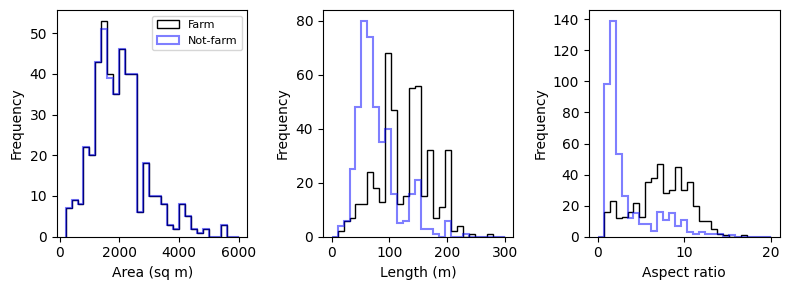

<Figure size 640x480 with 0 Axes>

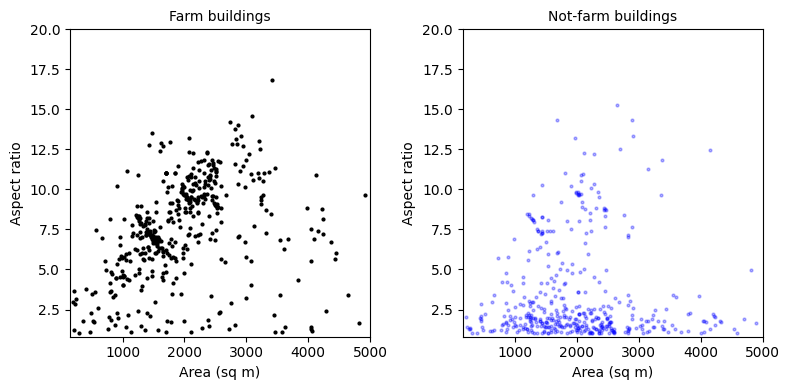

<Figure size 640x480 with 0 Axes>

In [ ]:
# Compare the distributions of farm and not-farm building characteristics

_ , axes = plt.subplots(1, 3, figsize=(8, 3))

for ax, col in zip(axes, ["Area (sq m)", "Length (m)", "Aspect ratio"]):
  ax.hist(final_farm_bldgs[col], bins=bins[col], histtype='step', color='k',\
          label="Farm")
  ax.hist(notfarm_buildings[col], bins=bins[col], histtype='step', color='b',\
          alpha=0.5, lw=1.5, label="Not-farm")
  if col == "Area (sq m)":
    ax.legend(fontsize=8)
  ax.set_ylabel("Frequency")
  ax.set_xlabel(col)
plt.tight_layout()
plt.show()
plt.savefig("/content/drive/MyDrive/CAFO_data/Analysis/Chile_final_histos.png")

def axis_stuff(ax, label):
  ax.set_xlim(min_building_size-50, 5000)
  ax.set_ylim(0.8, 20)
  ax.set_xlabel(f'Area (sq m)')
  ax.set_ylabel(f'Aspect ratio')
  ax.set_title(label, fontsize=10)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.plot(final_farm_bldgs["Area (sq m)"], final_farm_bldgs["Aspect ratio"], 'ko', ms=2)
axis_stuff(ax1, "Farm buildings")
ax2.plot(notfarm_buildings["Area (sq m)"], notfarm_buildings["Aspect ratio"],\
        'bo', ms=2, alpha=0.3)
axis_stuff(ax2, "Not-farm buildings")
plt.tight_layout()
plt.show()
plt.savefig("/content/drive/MyDrive/CAFO_data/Analysis/Chile_final_aspect_area.png")

The not-farm dataset contains quite a lot of buildings in the region of the aspect-area diagram where you'd expect CAFOs to be. Visual inspection shows that a lot of them are indeed CAFOs, presumably ones with inaccurate coordinates in the official records. We will drop those from the not-farm sample and add them to the CAFO dataset (with Farm type = Unknown). There could also be contamination in other regions of the diagram, but for now we will try training the model and see how it goes.




In [ ]:
to_check = notfarm_buildings[notfarm_buildings['Aspect ratio'] > 5]
bad2 = []
bad2 = loop_over_buildings(to_check)

Working on feature 0 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
16,"POLYGON ((-70.92692 -33.07595, -70.92694 -33.0...",717,65,6


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 1 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
27,"POLYGON ((-70.72386 -33.64111, -70.72364 -33.6...",975,83,7


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 2 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
32,"POLYGON ((-72.50630 -38.25084, -72.50672 -38.2...",879,74,6


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 3 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
53,"POLYGON ((-71.06899 -34.24612, -71.06910 -34.2...",1196,103,8


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 4 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
67,"POLYGON ((-70.83771 -34.17828, -70.83872 -34.1...",1283,103,8


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 5 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
74,"POLYGON ((-71.41156 -33.62667, -71.41157 -33.6...",1375,101,7


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 6 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
75,"POLYGON ((-72.71537 -36.81081, -72.71549 -36.8...",1289,113,10


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 7 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
80,"POLYGON ((-71.65055 -35.43292, -71.65046 -35.4...",1348,92,6


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 8 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
84,"POLYGON ((-70.83916 -34.17836, -70.84015 -34.1...",1303,103,8


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 9 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
87,"POLYGON ((-71.32658 -35.40120, -71.32666 -35.4...",1286,104,8


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 10 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
88,"POLYGON ((-70.83702 -34.17329, -70.83707 -34.1...",1227,103,8


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 11 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
89,"POLYGON ((-70.29493 -18.35843, -70.29504 -18.3...",1250,102,8


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 12 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
97,"POLYGON ((-70.75867 -34.34956, -70.75974 -34.3...",1266,102,8


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 13 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
98,"POLYGON ((-70.62654 -34.09179, -70.62658 -34.0...",1378,102,7


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 14 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
100,"POLYGON ((-70.96527 -34.74169, -70.96517 -34.7...",1225,97,6


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 15 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
103,"POLYGON ((-70.86308 -34.20324, -70.86313 -34.2...",1218,102,8


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 16 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
104,"POLYGON ((-70.77755 -34.41795, -70.77814 -34.4...",1210,84,6


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 17 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
105,"POLYGON ((-71.64548 -33.89477, -71.64562 -33.8...",1359,102,7


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 18 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
109,"POLYGON ((-71.15427 -34.73902, -71.15512 -34.7...",1440,112,8


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 19 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
117,"POLYGON ((-71.25076 -33.04885, -71.25086 -33.0...",1561,109,7


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 20 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
123,"POLYGON ((-70.86047 -34.19981, -70.86050 -34.1...",1529,103,5


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 21 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
124,"POLYGON ((-71.59929 -34.24943, -71.60037 -34.2...",1494,100,7


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 22 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
126,"POLYGON ((-71.15427 -34.73902, -71.15512 -34.7...",1440,112,8


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 23 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
129,"POLYGON ((-70.82248 -34.07871, -70.82253 -34.0...",1431,103,7


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 24 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
131,"POLYGON ((-71.59106 -35.45843, -71.59109 -35.4...",1540,112,8


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 25 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
133,"POLYGON ((-70.75625 -34.35118, -70.75732 -34.3...",1432,103,7


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 26 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
134,"POLYGON ((-71.20222 -32.65452, -71.20238 -32.6...",1523,125,7


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 27 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
144,"POLYGON ((-70.82094 -34.07826, -70.82099 -34.0...",1428,104,7


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 28 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
145,"POLYGON ((-71.63562 -33.96716, -71.63668 -33.9...",1526,102,6


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 29 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
149,"POLYGON ((-71.57825 -33.91071, -71.57828 -33.9...",1413,102,7


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 30 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
153,"POLYGON ((-70.62667 -34.09278, -70.62732 -34.0...",1409,101,6


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 31 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
156,"POLYGON ((-71.25740 -32.73367, -71.25741 -32.7...",1435,122,10


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 32 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
169,"POLYGON ((-70.76392 -33.69944, -70.76313 -33.6...",1699,128,6


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 33 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
172,"POLYGON ((-71.58013 -34.25790, -71.58106 -34.2...",1680,103,6


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 34 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
180,"POLYGON ((-70.96103 -34.46531, -70.96058 -34.4...",1678,157,14


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 35 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
181,"POLYGON ((-70.12673 -20.29489, -70.12764 -20.2...",1760,98,5


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 36 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
187,"POLYGON ((-71.69831 -35.44389, -71.69940 -35.4...",1614,111,7


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 37 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
189,"POLYGON ((-71.26241 -33.69123, -71.26241 -33.6...",1748,127,9


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 38 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
199,"POLYGON ((-70.20287 -18.51600, -70.20372 -18.5...",1719,93,5


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 39 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
204,"POLYGON ((-71.48026 -33.64185, -71.48026 -33.6...",1977,140,10


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 40 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
210,"POLYGON ((-71.23731 -32.78255, -71.23749 -32.7...",1925,110,5


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 41 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
211,"POLYGON ((-70.73637 -34.09033, -70.73656 -34.0...",1804,148,11


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 42 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
213,"POLYGON ((-71.47705 -33.67263, -71.47703 -33.6...",1907,140,10


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 43 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
221,"POLYGON ((-71.34808 -33.59650, -71.34807 -33.5...",1991,140,10


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 44 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
228,"POLYGON ((-71.55220 -33.78131, -71.55226 -33.7...",1842,123,8


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 45 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
234,"POLYGON ((-70.21735 -18.42226, -70.21735 -18.4...",1965,162,13


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 46 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
235,"POLYGON ((-70.74861 -33.24744, -70.74861 -33.2...",1902,132,8


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 47 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
237,"POLYGON ((-71.40843 -33.14527, -71.40843 -33.1...",2122,138,9


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 48 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
238,"POLYGON ((-71.28785 -34.98452, -71.28806 -34.9...",2118,106,5


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 49 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
240,"POLYGON ((-71.28519 -33.68255, -71.28669 -33.6...",2010,139,10


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 50 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
242,"POLYGON ((-71.23255 -32.53064, -71.23258 -32.5...",2066,149,11


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 51 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
244,"POLYGON ((-70.13221 -20.20003, -70.13224 -20.2...",2172,124,6


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 52 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
249,"POLYGON ((-71.46829 -33.67214, -71.46827 -33.6...",2086,139,9


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 53 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
253,"POLYGON ((-71.47489 -33.64557, -71.47640 -33.6...",2034,141,10


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 54 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
256,"POLYGON ((-71.24500 -32.51936, -71.24499 -32.5...",2078,151,9


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 55 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
257,"POLYGON ((-71.27069 -33.69407, -71.27069 -33.6...",2027,140,10


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 56 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
258,"POLYGON ((-71.25286 -32.51607, -71.25286 -32.5...",2065,151,11


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 57 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
261,"POLYGON ((-71.46067 -33.61824, -71.46067 -33.6...",2071,144,10


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 58 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
267,"POLYGON ((-70.78066 -34.15877, -70.78066 -34.1...",2111,163,12


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 59 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
268,"POLYGON ((-71.47505 -33.63024, -71.47655 -33.6...",2018,141,10


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 60 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
269,"POLYGON ((-71.22943 -33.72041, -71.22943 -33.7...",2011,141,10


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 61 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
271,"POLYGON ((-71.24342 -32.52090, -71.24342 -32.5...",2144,150,7


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 62 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
273,"POLYGON ((-70.88882 -33.39559, -70.88881 -33.3...",2093,152,11


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 63 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
275,"POLYGON ((-71.34564 -33.82563, -71.34552 -33.8...",2033,136,8


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 64 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
279,"POLYGON ((-71.48799 -33.64103, -71.48795 -33.6...",2127,142,7


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 65 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
283,"POLYGON ((-71.50987 -33.56600, -71.50987 -33.5...",2233,155,10


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 66 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
293,"POLYGON ((-71.52157 -33.57272, -71.52158 -33.5...",2273,153,10


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 67 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
294,"POLYGON ((-70.74684 -33.66498, -70.74832 -33.6...",2205,137,9


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 68 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
298,"POLYGON ((-71.25019 -32.49480, -71.25019 -32.4...",2211,151,8


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 69 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
302,"POLYGON ((-71.60409 -33.69497, -71.60409 -33.6...",2359,153,10


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 70 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
307,"POLYGON ((-71.15619 -33.50606, -71.15616 -33.5...",2348,153,10


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 71 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
309,"POLYGON ((-70.24759 -19.18452, -70.24762 -19.1...",2281,170,12


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 72 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
318,"POLYGON ((-70.60438 -34.03148, -70.60463 -34.0...",2311,166,9


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 73 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
321,"POLYGON ((-71.25178 -32.48874, -71.25131 -32.4...",2224,153,7


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 74 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
324,"POLYGON ((-70.26799 -18.42605, -70.26804 -18.4...",2461,144,8


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 75 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
331,"POLYGON ((-70.54615 -34.23351, -70.54523 -34.2...",2465,150,9


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 76 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
335,"POLYGON ((-71.39806 -33.33310, -71.39824 -33.3...",2457,139,8


Enter keep to keep, reject to reject, exit to exit  keep
Working on feature 77 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
345,"POLYGON ((-70.56602 -34.24054, -70.56496 -34.2...",2461,150,9


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 78 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
351,"POLYGON ((-70.61333 -34.01850, -70.61479 -34.0...",2433,148,9


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 79 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
359,"POLYGON ((-70.59901 -34.02813, -70.60031 -34.0...",2441,148,9


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 80 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
363,"POLYGON ((-71.37854 -33.92785, -71.37853 -33.9...",2642,201,15


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 81 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
365,"POLYGON ((-71.51564 -33.62442, -71.51562 -33.6...",2769,153,8


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 82 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
368,"POLYGON ((-71.05233 -33.82786, -71.05302 -33.8...",2691,186,13


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 83 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
375,"POLYGON ((-71.58054 -34.21369, -71.57833 -34.2...",2887,204,14


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 84 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
377,"POLYGON ((-70.87429 -34.20583, -70.87428 -34.2...",2830,154,7


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 85 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
383,"POLYGON ((-70.87288 -34.20401, -70.87443 -34.2...",2829,154,7


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 86 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
385,"POLYGON ((-70.64925 -34.04810, -70.64994 -34.0...",2883,155,8


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 87 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
386,"POLYGON ((-71.58568 -34.22166, -71.58567 -34.2...",2899,204,13


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 88 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
395,"POLYGON ((-71.65022 -33.97664, -71.65060 -33.9...",3145,201,11


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 89 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
398,"POLYGON ((-71.57625 -34.20337, -71.57625 -34.2...",3351,204,10


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 90 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
402,"POLYGON ((-71.63001 -33.98690, -71.63001 -33.9...",3368,203,12


Enter keep to keep, reject to reject, exit to exit  reject
Working on feature 91 of 92


,geometry,Area (sq m),Length (m),Aspect ratio
425,"POLYGON ((-71.45510 -35.53694, -71.45527 -35.5...",4152,231,12


Enter keep to keep, reject to reject, exit to exit  keep


In [ ]:
# Remove the CAFOs from the non-farm dataset
notfarms_cleaned = notfarm_buildings.drop(bad2)

print(f'Dropped {len(bad2)} CAFOs from the not-farm dataset')
print(f"There are {len(notfarms_cleaned)} not-farms in the final training dataset")

# Remove the not-farms from the farm dataset
farms_cleaned = final_farm_bldgs.drop(bad)

# Create a new df containing the CAFOs dropped from the not-farm dataset, with
# Farm type = Unknown as I don't have farm labels for these, and add it to the
# farm dataset
new_cafos = notfarm_buildings.loc[bad2, :]
new_cafos.loc[:, "Farm type"] = "Unknown"
new_cafos.loc[:, "Number of animals"] = np.nan
new_cafos.loc[:, "CRS"] = ""
new_cafos.loc[:, "Parent coords"] = None
farms_cleaned = pd.concat([farms_cleaned, new_cafos])

print(f'\nDropped {len(bad)} not-CAFOs from the farm dataset')
print(f'Added {len(bad2)} CAFOs to the farm dataset')

print(f"\nThere are {len(farms_cleaned)} farms in the final training dataset")
print(f" -- {len(farms_cleaned[farms_cleaned['Farm type'] == 'Pig'])} pigs")
print(f" -- {len(farms_cleaned[farms_cleaned['Farm type'] == 'Poultry'])} poultry")
print(f" -- {len(farms_cleaned[farms_cleaned['Farm type'] == 'Unknown'])} unknown")

Dropped 75 CAFOs from the not-farm dataset
There are 363 not-farms in the final training dataset

Dropped 21 not-CAFOs from the farm dataset
Added 75 CAFOs to the farm dataset

There are 504 farms in the final training dataset
 -- 143 pigs
 -- 286 poultry
 -- 75 unknown


<ipython-input-168-b4e60d09528f>:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  farms_cleaned = pd.concat([farms_cleaned, new_cafos])


## The final training dataset

In [ ]:
# Create the final dataset that will be used for training.

# -- Farm buildings
farms_cleaned.loc[:, "Dataset name"] = "Chile"
farms_cleaned = explore.re_order(farms_cleaned)

# -- Not-farm buildings
coldict = {"Dataset name": "Chile", "Parent coords": None,\
           "Farm type": "Non-farm", "Number of animals": np.nan}
for col, val in coldict.items():
  notfarms_cleaned.loc[:, col] = val

notfarms_cleaned = explore.re_order(notfarms_cleaned)

chl = pd.concat([farms_cleaned, notfarms_cleaned])
chl.to_pickle(f'/content/drive/MyDrive/CAFO_data/forTraining/interim_files/Chile_bldgs.pkl')

Saving 504 farms
